## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import random
import networkx as nx
import scipy.stats as stats
from scipy.stats import chisquare,poisson,binom
from collections import Counter

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

#visualizations
import matplotlib.pyplot as plt

## Constants

In [2]:
# Path constants
path="artifacts"
data_path = "../data/"
metadata_path = data_path + "sample_metadata.tsv"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
saved_path = "runs_results/models"
node_labels_path = "node_names.tsv"
node_labels = [x.split("\t")[0] for x in list(pd.read_csv(node_labels_path).iloc[:,0])]
model_obj_path = "model_runs/"

# Data preprocessing constants
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
has_val_set = False

# Model architecture
model_arch = {
    "model":DGCNN,
    "chans" : 5,
    "electrodes" : 22,
    "outputs" : 5,
    "layers" : 2,
    "hid_chans" : 16
    }

# Training parameters
train_dict = {
    "lr": 1e-4,
    "epochs": 40,
    "w_decay": 1e-3,
    }

#Models 
model_meta ={
    "amount":1,
    "plot":True,
    "plot_extensive": False,
    "new_models":True,
    "name": "dgcnn_mod"
    }

### Read data

In [3]:
## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(metadata_path, sep='\t')

# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [4]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=42)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=42)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train models

In [5]:
def train_models(modeltrainer,dict_model_arch, dict_training,dict_model_meta, path=path):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    mods = []
    for i in range(dict_model_meta["amount"]):   
            tmp_mod = dict_model_arch["model"](in_channels=dict_model_arch["chans"], 
                                            num_electrodes=dict_model_arch["electrodes"], 
                                            hid_channels=dict_model_arch["hid_chans"], 
                                            num_layers=dict_model_arch["layers"],
                                            num_classes=dict_model_arch["outputs"])
            
            mod_name=dict_model_meta["name"]
            
            model_path=f"{path}/{mod_name}_{i}.pth"

            if dict_model_meta["amount"]>1:
                print(f"Model {i+1}")
                
            if not os.path.exists(model_path):
                    print(f"[train_models]: Could not resolve path: {model_path}")
                    dict_model_meta["new_models"]=True
                
            if dict_model_meta["new_models"] or not os.path.exists(model_path):
                
                print(f"[train_models]: Training new models")
                trainer = modeltrainer()
                
                mods.append(trainer.train_model(tmp_mod, train_loader, 
                                                    path=model_path,
                                                    name=mod_name,
                                                    has_val_set=False,
                                                    val_loader=None,
                                                    learning_rate=dict_training["lr"],
                                                    w_decay=dict_training["w_decay"],
                                                    epochs=dict_training["epochs"], 
                                                    prints=dict_model_meta["plot"],
                                                    modrun=i))   
            else:
                print(f"[train_models]: Loading models from {model_path}")
                tmp_mod.load_state_dict(torch.load(model_path))
                tmp_mod.eval()
                mods.append([tmp_mod,[]])
    return mods

In [6]:
def seed_all(seed):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def run_models_hpc(param_list, n_runs, dict_model_arch, dict_training, dict_model_meta):

    run_idx = 1
    while run_idx < n_runs:
        random_seed = random.randint(0, 999999)
        seed_all(random_seed)
        path_name = model_obj_path + f"run_{run_idx}_seed_{random_seed}"
        print(f"[run_models_hpc] : Run idx: {run_idx}  | Curr seed: {random_seed}")
        print(f"[run_models_hpc] : Model dir: {path_name}")
        os.makedirs(path_name)
        models_dict = dict([(x, []) for x in param_list])
        
        for n_chans in param_list:
            model_name = f"model_chans_{n_chans}_seed_{random_seed}"
            
            new_dict_arch = dict_model_arch
            new_dict_arch["hid_chans"] = n_chans
            
            new_dict_meta = dict_model_meta
            new_dict_meta["name"] = model_name
            
            curr_model = [x[0] for x in train_models(TrainNN, new_dict_arch, dict_training,
                                                     new_dict_meta, path=path_name)]
            models_dict[n_chans].extend(curr_model)
        
        run_idx += 1


In [7]:
model_objs = mu.read_saved_models("model_runs/")

In [8]:
all_models = mu.get_all_models(model_objs)

train_avg, test_avg, difs_avg, train_std, test_std, difs_std = mu.avg_performance(all_models, X_train, y_train,
                                                                                  X_test, y_test, prints=True)

Average models training accuracy: 0.718
Average models test accuracy: 0.489
Average models training-test accuracy difference: 0.229
Models training accuracy SD: 0.064
Models test accuracy SD: 0.012
Models training-test accuracy difference SD: 0.060


In [9]:
def get_centers(lst):
    bary_list = []
    [bary_list.extend(x) for x in lst]
    return bary_list

def group_barycenters(lst,mapper):
    return list(map(mapper,lst))

def FCCPP_group(lst):
    return group_barycenters(lst,lambda a: 1 if a<6 else 2 if a<13 else 3 if a <18 else 4)

In [10]:
model_chans, bary_chans, sims_chans= mu.metrics_by_chans(model_objs)

graph not connected
graph not connected


In [11]:
betweeness_nodes = gu.get_max_betweeness_nodes(model_chans)
laplacian_centrality_nodes = gu.get_max_laplacian_centrality_nodes(model_chans)
current_flow_betweeness_nodes = gu.get_max_current_flow_betweeness_nodes(model_chans)

graph not connected
graph not connected


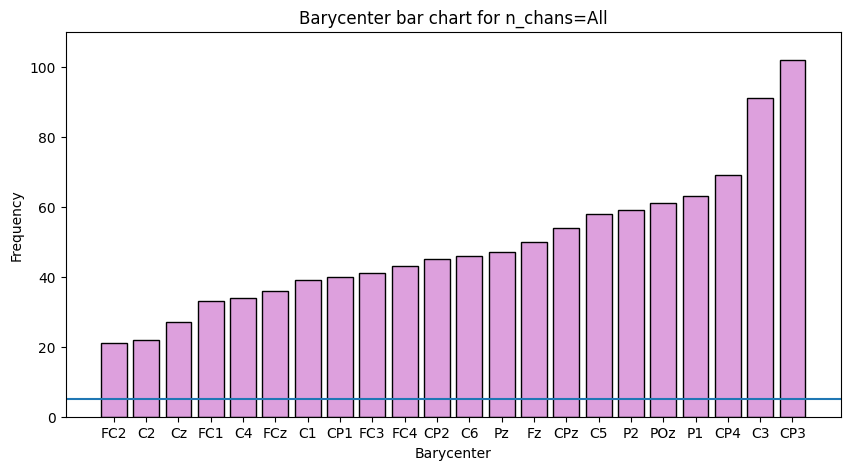

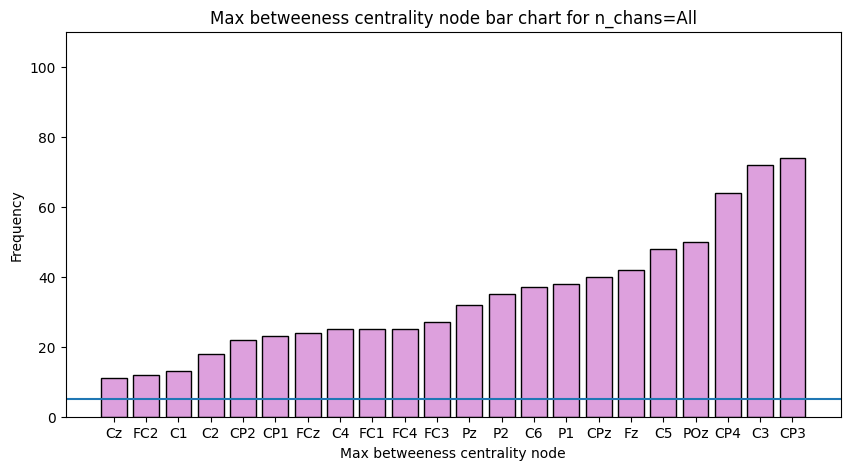

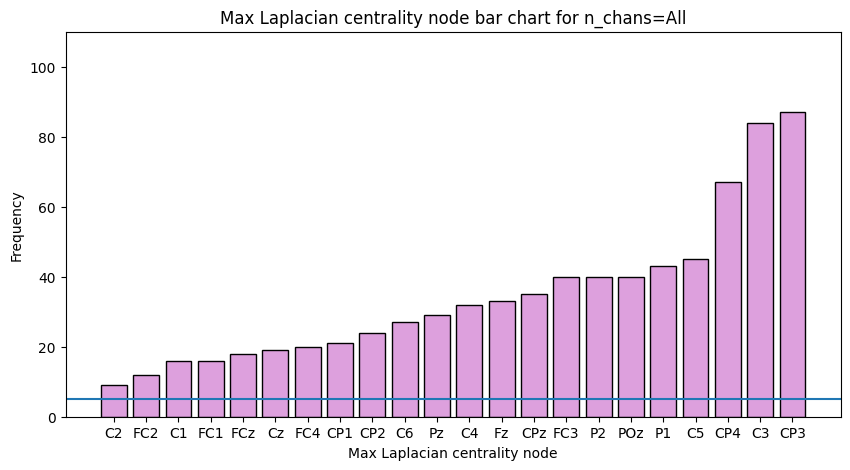

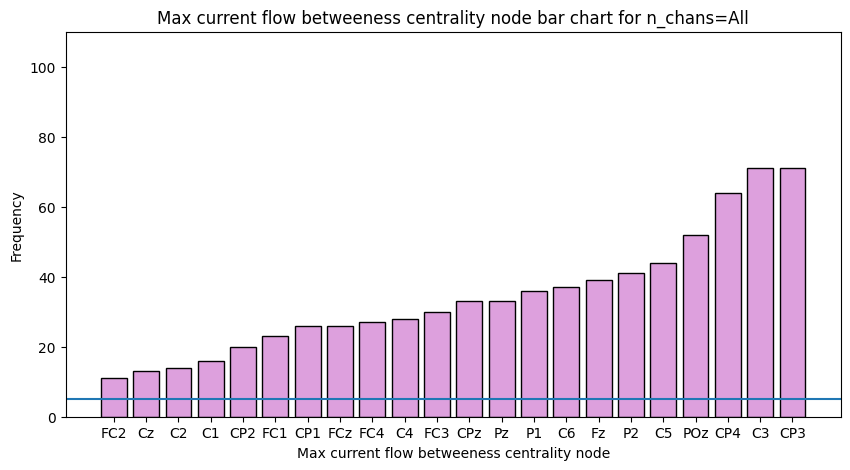

In [12]:
vu.dict_to_histogram(bary_chans, "All", node_labels, "Barycenter")
vu.dict_to_histogram(betweeness_nodes, "All", node_labels, "Max betweeness centrality node")
vu.dict_to_histogram(laplacian_centrality_nodes, "All", node_labels, "Max Laplacian centrality node")
vu.dict_to_histogram(current_flow_betweeness_nodes, "All", node_labels, "Max current flow betweeness centrality node")
#for n_chans in bary_chans.keys():
    #vu.dict_to_histogram({n_chans: bary_chans[n_chans]}, n_chans, node_labels)

In [23]:
untrained_mods = dict()

for seed in model_objs:
    seed_all(seed)
    untrained_mods[seed] = dict()
    for n_chans in model_objs[seed]:  
        untrained_mods[seed][n_chans] = DGCNN(in_channels=model_arch["chans"], 
                        num_electrodes=model_arch["electrodes"], 
                        hid_channels=n_chans, 
                        num_layers=model_arch["layers"],
                        num_classes=model_arch["outputs"]).eval()
        
unt_model_chans, unt_bary_chans, unt_sims_chans = mu.metrics_by_chans(untrained_mods)
unt_bet_dict = gu.get_max_betweeness_nodes(unt_model_chans)
unt_lap_dict = gu.get_max_laplacian_centrality_nodes(unt_model_chans)
unt_cf_dict = gu.get_max_current_flow_betweeness_nodes(unt_model_chans)

In [14]:
freqs_by_chan, node_counts_all, all_bary = gu.get_bary_counts(bary_chans)
_,unt_node_all,unt_bary_all=gu.get_bary_counts(unt_bary_chans)

In [15]:
def chi2(node_counts_all,comp_set,ddof=0):
    observed_counts = np.array(node_counts_all)
    if abs(sum(observed_counts) - sum(comp_set)) < 0.0001:
            expected_counts = np.array(comp_set) #synthetic data 

    elif sum(observed_counts)<sum(comp_set):
        expected_counts=np.array(gu.shrink(comp_set,sum(observed_counts)))
    else:
        expected_counts=np.array(gu.grow(comp_set,sum(observed_counts)))
    
    chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts,ddof=ddof)
    print(f"Chi-squared statistic: {chi2_stat:.3g}")
    print(f"P-value: {p_value:.3g}")
    

def statistical_tests(counts, untrained_counts, metric_dict, metric_name, include_untrained=True):
    
    total = sum(counts)
   
    print(f"-----Tests for metric: {metric_name}-----\n")
    print("---Uniform test---")
    chi2(counts,np.full(22,total/22))
    print()
    
    #Likelihood
    likelihood=[round((counts[i]/total)*100,2) for i in range(len(counts))]
    print("----Likelyhood-----")
    print(likelihood)
    #uniform comparison
    uniform=(total/22)/total*100
    uniform_comp=[round((likelihood[i]/uniform)*100-100,2) for i in range(22)]
    print("----Uniform comparison-----")
    print(uniform_comp)
    print(f"Total/Differential")
    for i in range(22):
        print(f" {node_labels[i]}: {likelihood[i]}% : {uniform_comp[i]}% ")
        
    print("---Poisson test---")
    metric_sorted, _ = gu.get_sorted_metrics(metric_dict, node_labels)
    lambda_est = np.mean(metric_sorted)
    expected_poisson = [max(int(poisson.pmf(k, lambda_est) * sum(metric_sorted)),1) for k in range(22)]
    chi2(metric_sorted, expected_poisson,ddof=1)
    print()  
    
    if include_untrained:
        print("---Is altered from untrained?---")
        chi2(counts,untrained_counts)
        print()

In [24]:
bet_counts = vu.dict_to_counts(betweeness_nodes); unt_bet_counts = vu.dict_to_counts(unt_bet_dict)
lap_counts = vu.dict_to_counts(laplacian_centrality_nodes); unt_lap_counts = vu.dict_to_counts(unt_lap_dict)
cf_counts = vu.dict_to_counts(current_flow_betweeness_nodes); unt_cf_counts = vu.dict_to_counts(unt_cf_dict)

In [27]:
statistical_tests(cf_counts, unt_cf_counts, betweeness_nodes, "betweeness centrality")

-----Tests for metric: betweeness centrality-----

---Uniform test---
Chi-squared statistic: 186
P-value: 1.87e-28

----Likelyhood-----
[5.17, 3.97, 3.05, 3.44, 1.46, 3.58, 5.83, 9.4, 2.12, 1.72, 1.85, 3.71, 4.9, 9.4, 3.44, 4.37, 2.65, 8.48, 4.77, 4.37, 5.43, 6.89]
----Uniform comparison-----
[13.74, -12.66, -32.9, -24.32, -67.88, -21.24, 28.26, 106.8, -53.36, -62.16, -59.3, -18.38, 7.8, 106.8, -24.32, -3.86, -41.7, 86.56, 4.94, -3.86, 19.46, 51.58]
Total/Differential
 Fz: 5.17% : 13.74% 
 FC3: 3.97% : -12.66% 
 FC1: 3.05% : -32.9% 
 FCz: 3.44% : -24.32% 
 FC2: 1.46% : -67.88% 
 FC4: 3.58% : -21.24% 
 C5: 5.83% : 28.26% 
 C3: 9.4% : 106.8% 
 C1: 2.12% : -53.36% 
 Cz: 1.72% : -62.16% 
 C2: 1.85% : -59.3% 
 C4: 3.71% : -18.38% 
 C6: 4.9% : 7.8% 
 CP3: 9.4% : 106.8% 
 CP1: 3.44% : -24.32% 
 CPz: 4.37% : -3.86% 
 CP2: 2.65% : -41.7% 
 CP4: 8.48% : 86.56% 
 P1: 4.77% : 4.94% 
 Pz: 4.37% : -3.86% 
 P2: 5.43% : 19.46% 
 POz: 6.89% : 51.58% 
---Poisson test---
Chi-squared statistic: 197
P-valu

In [26]:
statistical_tests(lap_counts, unt_lap_counts, betweeness_nodes, "betweeness centrality")

-----Tests for metric: betweeness centrality-----

---Uniform test---
Chi-squared statistic: 276
P-value: 2.69e-46

----Likelyhood-----
[4.36, 5.28, 2.11, 2.38, 1.59, 2.64, 5.94, 11.1, 2.11, 2.51, 1.19, 4.23, 3.57, 11.49, 2.77, 4.62, 3.17, 8.85, 5.68, 3.83, 5.28, 5.28]
----Uniform comparison-----
[-4.08, 16.16, -53.58, -47.64, -65.02, -41.92, 30.68, 144.2, -53.58, -44.78, -73.82, -6.94, -21.46, 152.78, -39.06, 1.64, -30.26, 94.7, 24.96, -15.74, 16.16, 16.16]
Total/Differential
 Fz: 4.36% : -4.08% 
 FC3: 5.28% : 16.16% 
 FC1: 2.11% : -53.58% 
 FCz: 2.38% : -47.64% 
 FC2: 1.59% : -65.02% 
 FC4: 2.64% : -41.92% 
 C5: 5.94% : 30.68% 
 C3: 11.1% : 144.2% 
 C1: 2.11% : -53.58% 
 Cz: 2.51% : -44.78% 
 C2: 1.19% : -73.82% 
 C4: 4.23% : -6.94% 
 C6: 3.57% : -21.46% 
 CP3: 11.49% : 152.78% 
 CP1: 2.77% : -39.06% 
 CPz: 4.62% : 1.64% 
 CP2: 3.17% : -30.26% 
 CP4: 8.85% : 94.7% 
 P1: 5.68% : 24.96% 
 Pz: 3.83% : -15.74% 
 P2: 5.28% : 16.16% 
 POz: 5.28% : 16.16% 
---Poisson test---
Chi-squared sta

In [25]:
statistical_tests(bet_counts, unt_bet_counts, betweeness_nodes, "betweeness centrality")

-----Tests for metric: betweeness centrality-----

---Uniform test---
Chi-squared statistic: 200
P-value: 3.28e-31

----Likelyhood-----
[5.55, 3.57, 3.3, 3.17, 1.59, 3.3, 6.34, 9.51, 1.72, 1.45, 2.38, 3.3, 4.89, 9.78, 3.04, 5.28, 2.91, 8.45, 5.02, 4.23, 4.62, 6.61]
----Uniform comparison-----
[22.1, -21.46, -27.4, -30.26, -65.02, -27.4, 39.48, 109.22, -62.16, -68.1, -47.64, -27.4, 7.58, 115.16, -33.12, 16.16, -35.98, 85.9, 10.44, -6.94, 1.64, 45.42]
Total/Differential
 Fz: 5.55% : 22.1% 
 FC3: 3.57% : -21.46% 
 FC1: 3.3% : -27.4% 
 FCz: 3.17% : -30.26% 
 FC2: 1.59% : -65.02% 
 FC4: 3.3% : -27.4% 
 C5: 6.34% : 39.48% 
 C3: 9.51% : 109.22% 
 C1: 1.72% : -62.16% 
 Cz: 1.45% : -68.1% 
 C2: 2.38% : -47.64% 
 C4: 3.3% : -27.4% 
 C6: 4.89% : 7.58% 
 CP3: 9.78% : 115.16% 
 CP1: 3.04% : -33.12% 
 CPz: 5.28% : 16.16% 
 CP2: 2.91% : -35.98% 
 CP4: 8.45% : 85.9% 
 P1: 5.02% : 10.44% 
 Pz: 4.23% : -6.94% 
 P2: 4.62% : 1.64% 
 POz: 6.61% : 45.42% 
---Poisson test---
Chi-squared statistic: 197
P-valu

In [16]:
statistical_tests(node_counts_all, unt_node_all, bary_chans, "barycenter")

-----Tests for metric: barycenter-----

---Uniform test---
Chi-squared statistic: 173
P-value: 8.42e-26

----Likelyhood-----
[4.63, 3.79, 3.05, 3.33, 1.94, 3.98, 5.37, 8.42, 3.61, 2.5, 2.04, 3.15, 4.26, 9.44, 3.7, 5.0, 4.16, 6.38, 5.83, 4.35, 5.46, 5.64]
----Uniform comparison-----
[1.86, -16.62, -32.9, -26.74, -57.32, -12.44, 18.14, 85.24, -20.58, -45.0, -55.12, -30.7, -6.28, 107.68, -18.6, 10.0, -8.48, 40.36, 28.26, -4.3, 20.12, 24.08]
Total/Differential
 Fz: 4.63% : 1.86% 
 FC3: 3.79% : -16.62% 
 FC1: 3.05% : -32.9% 
 FCz: 3.33% : -26.74% 
 FC2: 1.94% : -57.32% 
 FC4: 3.98% : -12.44% 
 C5: 5.37% : 18.14% 
 C3: 8.42% : 85.24% 
 C1: 3.61% : -20.58% 
 Cz: 2.5% : -45.0% 
 C2: 2.04% : -55.12% 
 C4: 3.15% : -30.7% 
 C6: 4.26% : -6.28% 
 CP3: 9.44% : 107.68% 
 CP1: 3.7% : -18.6% 
 CPz: 5.0% : 10.0% 
 CP2: 4.16% : -8.48% 
 CP4: 6.38% : 40.36% 
 P1: 5.83% : 28.26% 
 Pz: 4.35% : -4.3% 
 P2: 5.46% : 20.12% 
 POz: 5.64% : 24.08% 
---Poisson test---
Chi-squared statistic: 175
P-value: 7.96e-27



### Print model metrics

In [53]:
if model_meta["plot_extensive"]:
    for seed in model_objs:
        for chan in model_objs[seed]:
            print(f"Model {seed}, chan: {chan} test")
            mu.model_metrics(model_objs[seed][chan], X_train, y_train, X_test, y_test, None, None,plots=model_meta["plot"])
           

### Print adjacency matrices & graphs

In [54]:
graphs=dict()
adj_mats=dict()
for seed in model_objs:
    graphs[seed]=dict()
    adj_mats[seed]=dict()
    for chan in model_objs[seed]:
        if nx.is_connected(gu.make_graph(mu.get_adj_mat(model_objs[seed][chan]))):
            adj_mats[seed][chan]=mu.get_adj_mat(model_objs[seed][chan])
            graphs[seed][chan]=gu.make_graph(adj_mats[seed][chan])
        else:
            print("graph not connected")
if model_meta["plot_extensive"]:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
keys = list(graphs.keys())
for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        key1 = keys[i]
        key2 = keys[j]
        seed1 = graphs[key1]
        seed2 = graphs[key2]
        for chan1,G1 in seed1.items():
            for chan2,G2 in seed2.items():
                assert gu.check_not_isomorphism(G1,G2), f"Graph seed: {key1} chan:{chan1} and Graph seed: {key2} chan:{chan2}are isomophic"        

graph not connected
graph not connected


In [55]:
for seed in graphs:
    _bary_list=[]
    _adj_mats=[]
    for chans in graphs[seed]:
        _bary_list.append(gu.get_barycenter(adj_mats[seed][chans]))
        _adj_mats.append(adj_mats[seed][chans])
    if model_meta["plot_extensive"]:
        print(f"Graphs for seed: {seed}")
        vu.graph_plot(_adj_mats,vu.graph_visual,3,3,_bary_list)

### Plot CKA matrices

In [56]:
cka_all = []
keys = list(adj_mats.keys())
for i in range(min(len(keys),2)):
    for j in range(i + 1,min(len(keys),2)):
        key1 = keys[i]
        key2 = keys[j]
        seed1 = adj_mats[key1]
        seed2 = adj_mats[key2]
        for chan1,adj1 in seed1.items():
            for chan2,adj2 in seed2.items():
                calculator = CKACalculator(model1=model_objs[key1][chan1], 
                                model2=model_objs[key2][chan2], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
                cka_output = calculator.calculate_cka_matrix(train_dataset)
                cka_all.append(cka_output)
                if model_meta["plot_extensive"]:
                    vu.plot_matrix(f'CKA Matrix: Model {key1}:{chan1} vs Model {key2}:{chan2}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

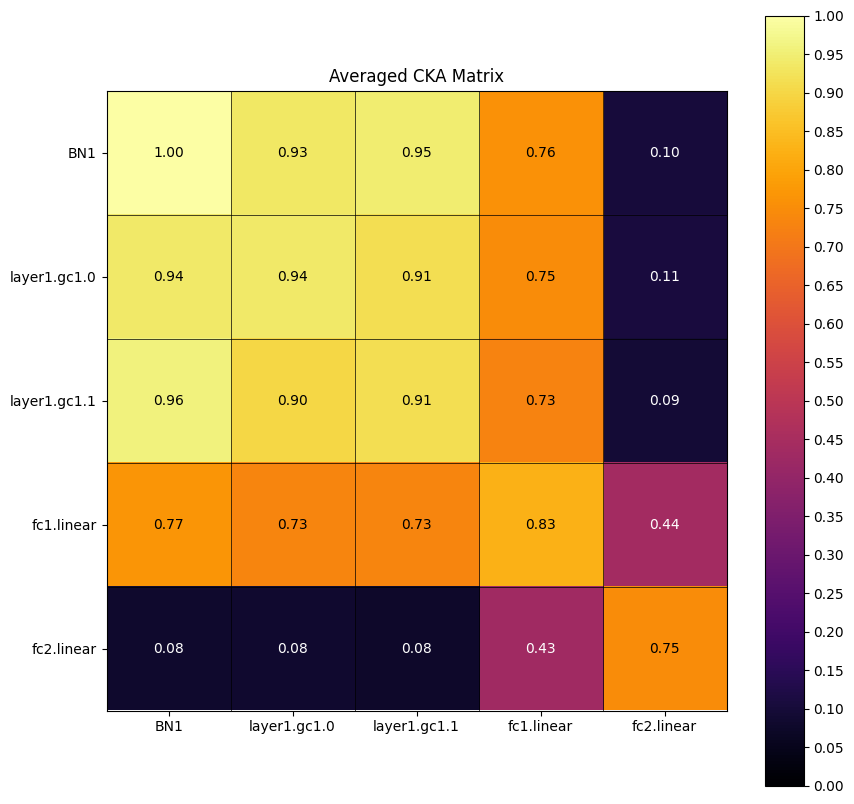

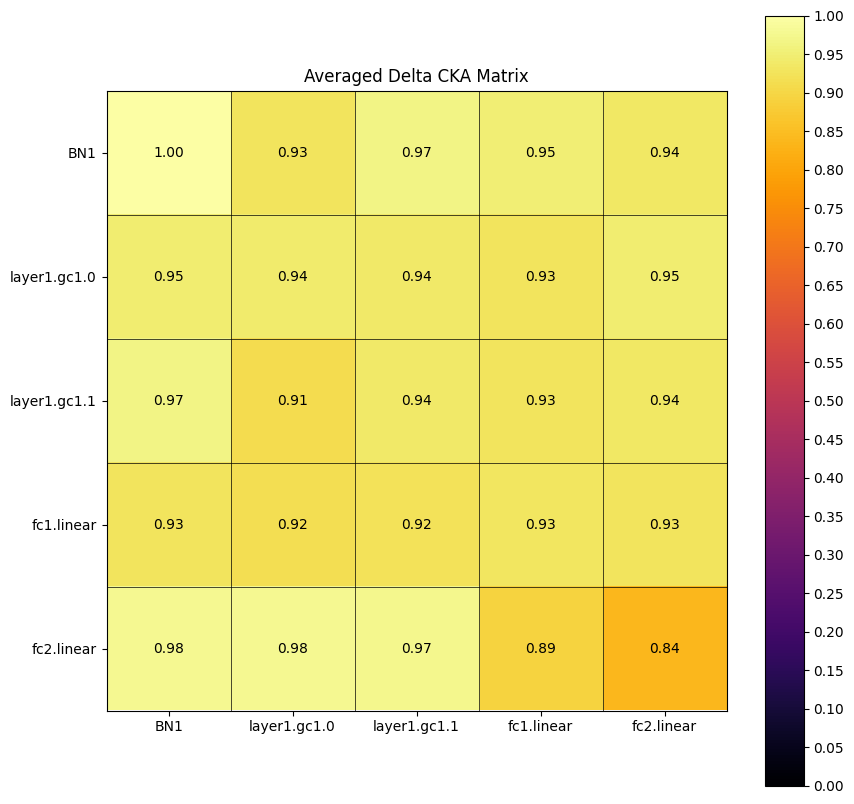

In [57]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if model_meta["plot"]:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)